In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geoplot

/home/irene/myenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NJ_map = gpd.read_file('/home/irene/ISEF-Project-2023/Data/NJMunicipal/Municipal_Boundaries_of_NJ.shp')
NJ_map = NJ_map.to_crs(epsg=4326)

In [3]:
df = pd.read_csv("DensityGDF.csv")

In [4]:
df["W"] = ""
df["X"] = ""
df["Y"] = ""
df["Z"] = ""

In [5]:
for i in range(len(df.index)):#42599):
    U = df.at[i, 'Upper'].split(', ')
    L = df.at[i, 'Lower'].split(', ')
    df.at[i,"W"] = float(U[0])
    df.at[i,"X"] = float(U[1])
    df.at[i,"Y"] = float(L[0])
    df.at[i,"Z"] = float(L[1])
    p1 = Point(float(L[1]),float(U[0]))
    p3 = Point(float(U[1]),float(L[0]))
    p2 = Point(float(L[1]),float(L[0]))
    p4 = Point(float(U[1]),float(U[0]))
    
    points = [p1,p2,p3,p4]
    px = (float(L[1])+float(U[1]))/2
    py = (float(L[0])+float(U[0]))/2

    df.at[i,'Geometry'] = Polygon([[p.x, p.y] for p in points])
    df.at[i,'x'] = px
    df.at[i,'y'] = py

In [6]:
for i in range(len(NJ_map.index)):
    s = 0
    p1 = NJ_map.at[i,"geometry"]
    count = 0
    for j in range(len(df.index)):
        p2 = df.at[j,"Geometry"]
        if (p2.intersects(p1)):
            count += 1
            s+=df.at[j,"pred"]
    print(count)
    '''
    if(count != 0):
        mean = float(s/count)
        print(mean)
        NJ_map.at[i,"mean"]= mean
    '''
    NJ_map.at[i,"mean"] = count

47
87
25
31
66
82
167
0
8
67
3
0
263
115
0
0
0
0
0
0
0
0
0
0
2
30
104
31
0
169
39
17
0
84
126
0
101
28
49
49
19
15
143
113
28
23
7
145
9
107
0
72
27
24
0
58
0
53
94
121
49
35
0
11
11
26
7
9
60
20
10
115
3
73
11
68
41
12
9
13
12
6
56
6
15
125
58
1
189
160
251
117
149
53
98
61
51
8
64
22
16
12
6
42
95
6
91
14
29
2
8
7
4
59
10
5
13
5
66
3
6
35
17
6
2
114
123
40
45
25
61
160
13
47
15
15
4
226
8
18
199
5
5
3
13
7
6
11
8
6
2
8
28
4
17
7
15
81
2
16
16
3
66
47
64
32
78
50
11
102
2
4
8
62
5
4
10
4
3
36
158
8
66
231
1
38
9
8
6
5
9
133
9
2
13
6
7
22
29
15
26
39
8
203
106
120
11
113
38
9
50
119
52
4
14
22
3
18
15
66
8
11
40
11
6
15
5
161
66
57
13
114
8
111
23
6
8
10
106
28
26
7
6
56
88
5
6
8
53
11
44
16
74
88
89
6
5
60
10
4
105
9
20
129
12
13
6
155
6
108
14
10
11
61
27
19
96
15
72
22
4
20
42
15
26
9
83
101
5
100
27
17
32
69
0
9
16
22
8
28
37
10
42
6
12
24
9
8
62
0
20
37
66
12
27
8
13
47
15
93
43
75
84
10
7
23
77
6
22
22
94
44
5
18
36
6
13
27
16
43
22
24
38
6
10
9
38
91
16
11
40
6
5
62
14
69
11
6
1

In [7]:
col = 'mean'
vmin = NJ_map[col].min()
vmax = NJ_map[col].max()

/home/irene/myenv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


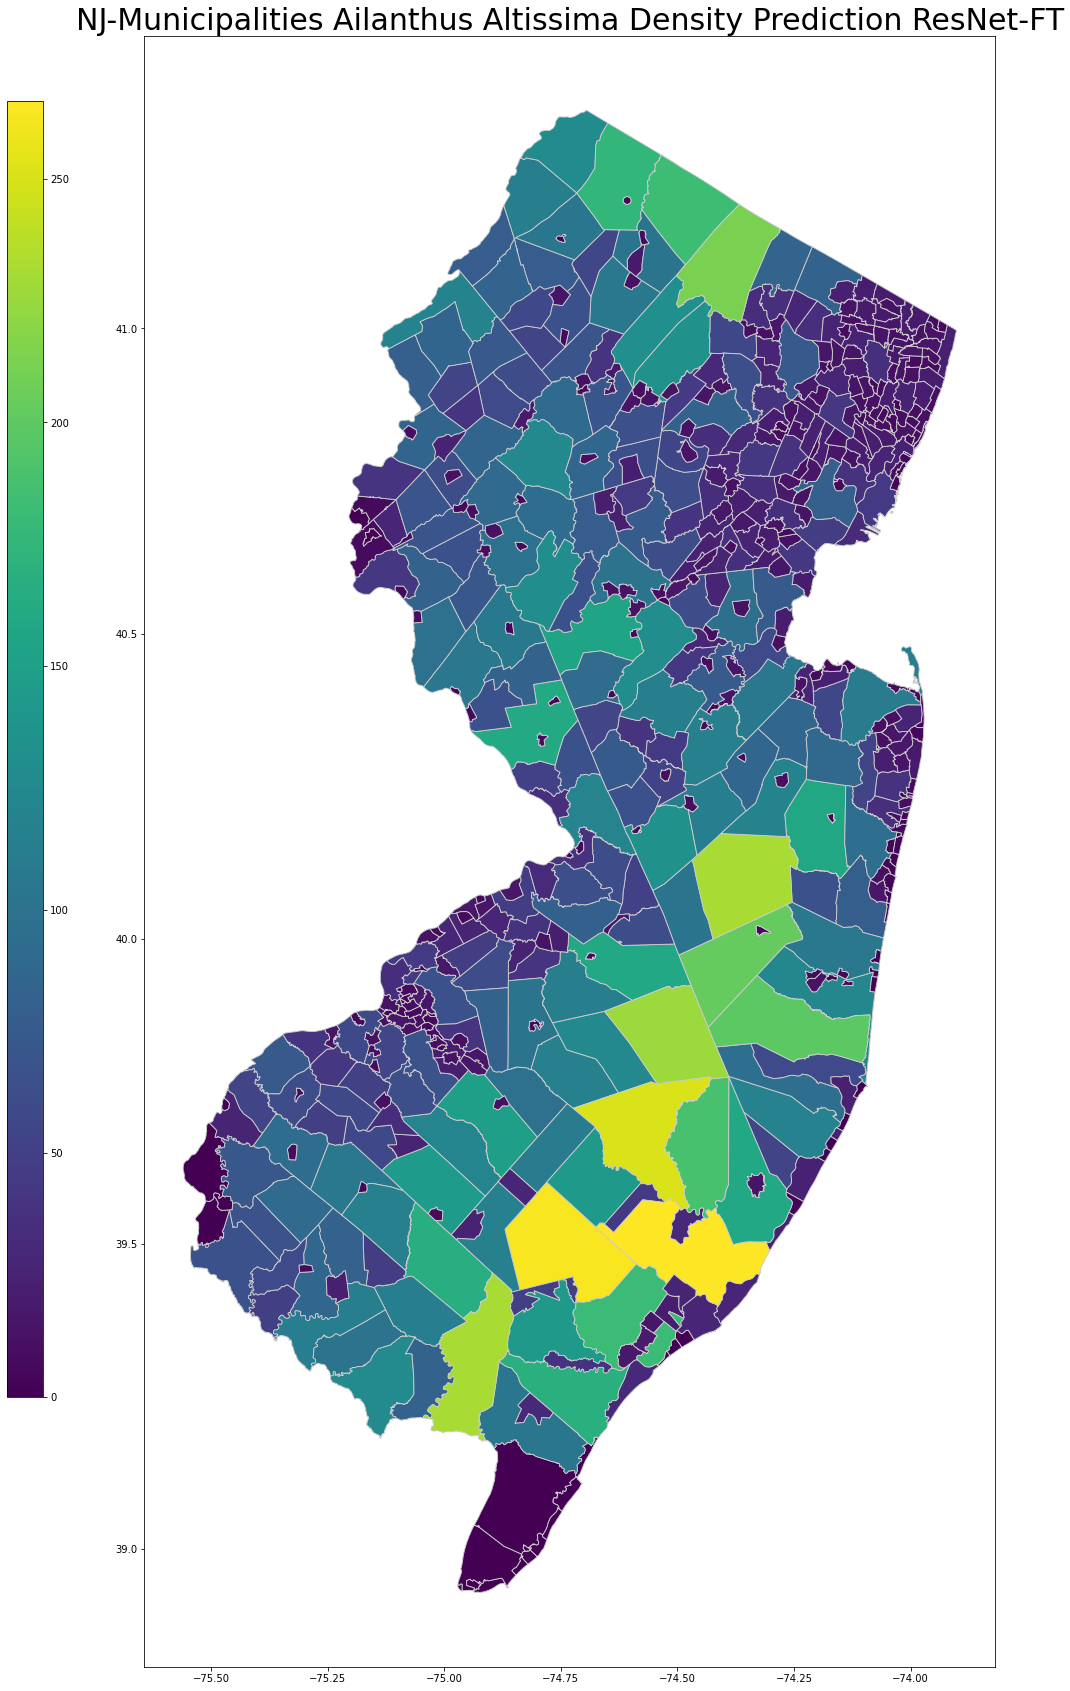

In [27]:
fig, ax = plt.subplots(
    1,
    figsize=(25, 30))
NJ_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
crs = {'init':'EPSG:4326'}
geo_df = gpd.GeoDataFrame(NJ_map, 
                          crs = crs, 
                          geometry = "geometry")
geo_df.plot(column=col, ax=ax, linewidth=0.9,
    edgecolor='0.8', cmap="viridis")
ax.set_title('NJ-Municipalities Ailanthus Altissima Density Prediction ResNet-FT',fontdict={'fontsize': 30})
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap="viridis")
sm._A = []
cbaxes = fig.add_axes([0.2, 0.25, 0.02, 0.6])
cbar = fig.colorbar(sm, cax=cbaxes)
